# Point vortices in the plane
This interactive notebook will produce movies of point vortices interacting in the plane. 

### Integrating the equations of motion
Read the accompanying `point_vortex_dynamics.pdf`, where you can find a derivation of the equations of motion for point vortices in the plane. Recall the equations of motion are:
\begin{align}
\dot{{\bf x}}_\alpha = \left( \sum_{\beta \neq \alpha}\frac{\Gamma_\beta(-y_\alpha+y_\beta)}{4 \pi^2\left | {\bf x_\alpha} - {\bf x_\beta} \right |^2}, \sum_{\beta \neq \alpha}\frac{\Gamma_\beta(x_\alpha - x_\beta)}{4 \pi^2 \left | {\bf x_\alpha} - {\bf x_\beta} \right |^2} \right),
\end{align}
where $\alpha$ and $\beta$ index the point vortices. As a warm-up, we'll numerically integrate the equations of motion using numpy's `solve_ivp()` function, which uses Runge-Kutta (5)4 and has a similar functionality to Matlab's `ode45()`. The following script initializes the point vortices and generates the solution for $t$-values in $[0,\mathrm{Tmax}]$, where $\mathrm{Tmax}$ is a user specified constant. 


In [45]:
import numpy as np
from scipy.integrate import solve_ivp

pi = np.pi
# Simulation setup

#initial conditions
Gamma=np.array([1,1,1])
Tmax=140
t_vals = np.linspace(0,Tmax,300)
print(t_vals[-1])
x=np.array([1, 3, 2])
y=np.array([3, 3, 3+2*np.cos(pi/6.0)])
pos = np.array(list(zip(x,y)))
x0 = pos.flatten()
N=len(Gamma) # number of vortices
colors = list(map(lambda x: 'b' if x<=0 else 'r',Gamma))

def f(x,Gamma):
    '''
    This function takes in a position x, which is a numpy array with shape (2N,).
    The array x encodes the positions by concatenating the (x,y)-coords of the
    point vortices. So if there are two point vortices with coords (1,1) and (2,4),
    respectively, then the corresponding x varible will be np.array([1,1,2,4]).

    Gamma is a numpy array with shape (N,) where Gamma[i] is the strength of the 
    i-th point vortex.

    This function returns a numpy array with the same shape as x that yields the
    velocity vector for the point vortices. The velocities are encoded the same 
    way that x encodes the position. 
    '''

    x = x.reshape(-1,2)
    vel = np.zeros(x.shape)
    for alpha in range(len(pos)):
        for beta in range(len(pos)):
            if alpha!=beta:
                dist_sq = (x[alpha,0]-x[beta,0])**2 + (x[alpha,1]-x[beta,1])**2
                vel[alpha,0] =vel[alpha,0]+Gamma[beta]*(-x[alpha,1]+x[beta,1])/(4*pi**2*dist_sq)
                vel[alpha,1] =vel[alpha,1]+Gamma[beta]*(x[alpha,0]-x[beta,0])/(4*pi**2*dist_sq)

    vel = vel.flatten()
    return vel

#solve the ODE for t-vals on the interval (0,Tmax) and make sure to evaluate the solution at t_eval
sol = solve_ivp(lambda t,x : f(x,Gamma), (0,Tmax), x0, t_eval = t_vals)

140.0


### Computing the streamfunction
We've integrated the equations of motion. However, to better understand the corresponding fluid (and how it evolves in time), we will compute the streamfunction for the point vortices. The velocity field of the fluid is tangent to the level curves of the stream function. So the level curves of the stream function yield the path that a tracer particle would follow in the fluid. These are called *flow lines*. The following script computes the streamfunction.  

In [50]:
#Reorganize the solution array. Indices are 0:vortex number, 1:coordinate, 2: t-val
pos = sol.y.reshape(N,2,len(sol.t))
print(pos[:,:,-1])

delta = 0.025
x = np.arange(0,10, delta)
y = np.arange(0,10, delta)
X,Y = np.meshgrid(x,y)

#get flow lines
def streamlines(X,Y,posx,posy,Gamma):
    '''
    This function takes in numpy arrays X and Y of shape (W,H), where W and H 
    are the width and height of the (x,y)-grid in the plane, respectively. 

    posx and posy are numpy arrays of shape (N,) that encode the x and y coordinates
    (respectively) of the point vortices. So posx[i] yields the x-coordinate of the
    ith vortex.

    Gamma is a numpy array with shape (N,) where Gamma[i] is the strength of the
    i-th point vortex.

    The function returns psi, a numpy array of size (W,H) that gives the value of the
    streamfunction at the grid points. So psi[i,j] gives the value of the streamfunction
    at (X[i],Y[j]).
    '''

    psi = 0.0*X+0.0*Y
    for i in range(N):
        dist= 2**(-53)+np.sqrt( (X-posx[i])**2+(Y-posy[i])**2);
        psi= psi-Gamma[i]/(4*pi**2)*np.log(dist);

    return psi


[[3.12964263 3.642961  ]
 [1.37835812 4.52284412]
 [1.49199924 2.56624569]]


### Animating the dynamics
Now that we've computed the trajectories of the point vortices and can compute the streamfunction that corresponds to a given vortex configuration, we animate the trajectories and streamfunction as they evolve in time. 

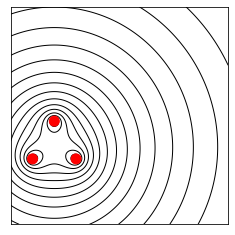

In [51]:
#animate the dynamics
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
levels = np.linspace(-0.30,0.30)

(fig, ax) = plt.subplots()

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

def animate(frame):

    ax.clear()

    frame = int(frame)
    xdata = pos[:,0,frame]
    ydata = pos[:,1,frame]
    Z = streamlines(X,Y,xdata,ydata,Gamma)
    ax.contour(X,Y,Z,levels, colors = 'k', linestyles = 'solid', linewidths = 1.0, zorder = -1)
    ax.scatter(xdata, ydata, s = np.abs(100*Gamma), c = colors)
    ax.set_aspect('equal','box')

ani = FuncAnimation(fig, animate, frames=range(len(sol.t)), repeat=True);
plt.gca().axes.get_yaxis().set_visible(False);
plt.gca().axes.get_xaxis().set_visible(False);
HTML(ani.to_html5_video())

## Bounded Domains in the plane:
Suppose that instead of being free to move anywhere in the plane, the point vortices are instead confined to a simply connected region $\Omega \subset \mathbb{R}^2$. 